<a href="https://colab.research.google.com/github/kashif/blog/blob/autoformer/electricity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q git+https://github.com/huggingface/transformers datasets evaluate accelerate "gluonts[torch]" ujson tqdm huggingface_hub
!pip install -q protobuf --upgrade # without it, the evaluation code fails

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.


In [4]:
from gluonts.dataset.repository.datasets import get_dataset

# traffic_dataset = get_dataset("traffic")
electricity_dataset = get_dataset("electricity")
# exchange_dataset = get_dataset("exchange_rate")

dataset = electricity_dataset

In [5]:
train_dataset = dataset.train
test_dataset = dataset.test
freq = dataset.metadata.freq
prediction_length = dataset.metadata.prediction_length

In [6]:
# Transformations

from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

from transformers import PretrainedConfig
from gluonts.time_feature import time_features_from_frequency_str

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [7]:
# InstanceSplitter

from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [8]:
# Dataloaders

from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream, is_train=True)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [9]:
# time_features and lags

from gluonts.time_feature import time_features_from_frequency_str
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
time_features = time_features_from_frequency_str(freq)

In [10]:
# Model & hyperparams

context_length = prediction_length*2
batch_size = 128
num_batches_per_epoch = 100
epochs = 50
scaling = "std"

encoder_layers=2
decoder_layers=2
d_model=16

from transformers import AutoformerConfig, AutoformerForPrediction

# Uncomment this for trainining
config = AutoformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length*2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # +1 for the age feature
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    # num_static_categorical_features=0,
    # it has 366 possible values:
    # cardinality=[len(train_dataset)],

    scaling=scaling,
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    # embedding_dimension=[2],
    encoder_layers=encoder_layers,
    decoder_layers=decoder_layers,
    d_model=d_model,
)

model = AutoformerForPrediction(config)

# # Uncomment this for pretrained
# config = AutoformerConfig.from_pretrained("elisim/autoformer-electricity-50-epochs_")
# model = AutoformerForPrediction.from_pretrained("elisim/autoformer-electricity-50-epochs_")

In [11]:
# train & test dataloaders

train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=batch_size,
    num_batches_per_epoch=num_batches_per_epoch,
    shuffle_buffer_length=1024,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

In [12]:
# Train

from accelerate import Accelerator
from torch.optim import AdamW

epochs = epochs
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 100 == 0:
            print(f"{loss.item():.3f}")

6.848
6.302
6.252
6.243
5.984
6.444
6.179
6.157
6.053
6.032
5.945
5.820
5.814
6.544
6.155
5.997
6.090
6.163
6.097
5.852
5.821
5.769
6.136
5.605
5.684
5.911
6.041
6.184
5.708
5.888
5.833
5.732
5.926
5.566
5.775
5.549
5.788
5.920
5.874
5.968
5.519
5.995
5.809
5.829
5.641
5.464
5.693
5.818
5.758
5.830


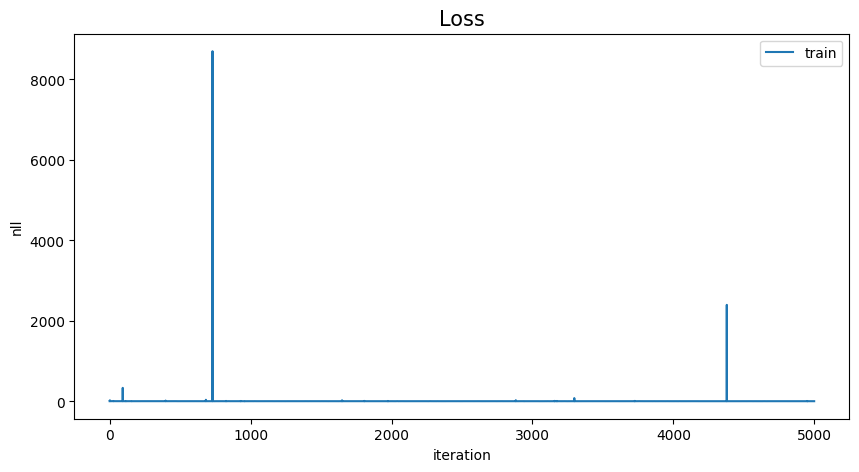

In [13]:
import matplotlib.pyplot as plt

# view training
x = range(len(loss_history))
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.show()

In [14]:
from huggingface_hub import notebook_login
notebook_login()

In [16]:
model.push_to_hub(f"elisim/autoformer-electricity-{epochs}-epochs_")

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/114k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/elisim/autoformer-electricity-50-epochs_/commit/dbdf27bf9754c41accc4a3818514ed7a28489ce1', commit_message='Upload AutoformerForPrediction', commit_description='', oid='dbdf27bf9754c41accc4a3818514ed7a28489ce1', pr_url=None, pr_revision=None, pr_num=None)

In [17]:
# Autoformer results
import numpy as np
from accelerate import Accelerator

accelerator = Accelerator()
device = accelerator.device
model.to(device)

model.eval()

forecasts_ = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

forecasts = np.vstack(forecasts_)
print(forecasts.shape)

(2247, 100, 24)


In [18]:
from tqdm.autonotebook import tqdm
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
for item_id, ts in enumerate(tqdm(test_dataset)):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])

print(f"Autoformer univariate MASE: {np.mean(mase_metrics):.3f}")

  0%|          | 0/2247 [00:00<?, ?it/s]

Autoformer univariate MASE: 0.751


In [19]:
# DLinear training

from gluonts.torch.model.d_linear.estimator import DLinearEstimator

estimator = DLinearEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    scaling=scaling,
    hidden_dimension=2,

    batch_size=batch_size,
    num_batches_per_epoch=num_batches_per_epoch,
    trainer_kwargs=dict(max_epochs=epochs)
)

predictor = estimator.train(
    training_data=train_dataset,
    cache_data=True,
    shuffle_buffer_length=1024
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | DLinearModel | 4.7 K 
---------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 100: 'train_loss' reached 6.68843 (best 6.68843), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 200: 'train_loss' reached 6.47661 (best 6.47661), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 300: 'train_loss' reached 6.24226 (best 6.24226), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=2-step=300.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 400: 'train_loss' reached 6.01421 (best 6.01421), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=3-step=400.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 500: 'train_loss' reached 5.86658 (best 5.86658), saving model to '/content/lightning_logs/version_0

In [20]:
# DLinear Eval

from gluonts.evaluation import make_evaluation_predictions, Evaluator

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

d_linear_forecasts = list(forecast_it)
d_linear_tss = list(ts_it)

evaluator = Evaluator()

agg_metrics, _ = evaluator(iter(d_linear_tss), iter(d_linear_forecasts))
dlinear_mase = agg_metrics["MASE"]

print(f"DLinear MASE: {dlinear_mase:.3f}")

Running evaluation: 2247it [00:00, 23965.68it/s]


DLinear MASE: 0.831


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
